In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os
import pickle
import json
from joblib import load

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, \
                           plot_confusion_matrix, classification_report, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE

In [52]:
from data_engineering.get_data import read_dataset, read_from_gcs
from data_engineering.preprocessing import preprocessing

# Configure GCS

First, extract the label where are interested in. The labels are saved in this order:
 - 0 -> project_short_name
 - 1 -> clinical_stage
 - 2 -> clinical_T
 - 3 -> clinical_N
 - 4 -> clinical_M
 - 5 -> pathologic_stage
 - 6 -> pathologic_T
 - 7 -> pathologic_N
 - 8 -> pathologic_M

In [53]:
#file_path = "gs://build_hackathon_dnanyc/training_data/tcga-brca-data-pathologic.csv"
file_path = "gs://build_hackathon_dnanyc/training_data/columns_to_keep_v4/tcga-brca-data-pathologic_stage.csv"
label_name = 'pathologic_stage'

In [54]:
betas, labels, cpg_sites, index = read_from_gcs(file_path, label_name)

In [55]:
labels

array(['Stage X', 'Stage IIB', 'Stage IIB', ..., 'Stage IIB',
       'Stage IIIA', 'Stage I'], dtype=object)

In [56]:
cpg_sites

Index(['cg00000292', 'cg00005847', 'cg00008493', 'cg00011459', 'cg00013618',
       'cg00020533', 'cg00022866', 'cg00025991', 'cg00031162', 'cg00033773',
       ...
       'cg27623214', 'cg27625732', 'cg27626424', 'cg27631256', 'cg27631817',
       'cg27641018', 'cg27643859', 'cg27651218', 'cg27652350', 'cg27653134'],
      dtype='object', length=5000)

# Pre-processing

In [57]:
sub_labels = labels

In [58]:
l = []
for (elt, barcode) in zip(sub_labels, index):
    sample_code = int(barcode.split('-')[-1][:2])
    if sample_code <= 9:
        l.append(elt)
    else:
        l.append(0)

In [59]:
map_sub_labels_to_classes = {
  'Stage I': 1,
  'Stage IA': 1,
  'Stage IB': 1,
  'Stage II': 2,
  'Stage IIA': 2,
  'Stage IIB': 2,
  'Stage III': 3,
  'Stage IIIA': 3,
  'Stage IIIB': 3,
  'Stage IIIC': 3,
  'Stage IV': 4,
  'Stage X': 5,
   np.nan: np.nan,
   0: 0
}

In [60]:
sub_labels = [map_sub_labels_to_classes[elt] for elt in l]

## Re-balance dataset

In [61]:
X_train, X_test, y_train, y_test, labels, cpg_sites = preprocessing(betas, sub_labels, cpg_sites, smote=True,
                                                                   fill_na_strategy='knn',
                                                                    sampling_strategy=1)

=== Drop Columns and Rows ===
Dropping 11 because of missing labels
New Shape = (1223, 5000)
Dropping columns which have more than 10% of values missing
0 columns will be dropped.
betas: New shape is (1223, 5000)
cpg_sites: New shape is (5000,)

Dropping rows which have more than 10% of values missing
We will drop 1 rows
betas: New shape is (1222, 5000)
labels: New shape is (1222,)

=== Fill remaining NAs ===
Filling remaining NA values using a KNNImputer
1740 NA were filled, i.e. approximately 1.42 per rows

=== Train / Test Split ===
Splitting dataset into train and test
Train = 70 %
Test = 30 %

=== Standardize dataset ===
The average of column mean on train is 0.00
The average of column mean on test is -0.01

=== Balance dataset ===
[(0.0, 84), (1.0, 130), (2.0, 446), (3.0, 171), (4.0, 14), (5.0, 10)]
The resampling_strategy gives the following repartition {0.0: 446, 1.0: 446, 2.0: 446, 3.0: 446, 4.0: 446, 5.0: 446}
1821 rows were added in the training data


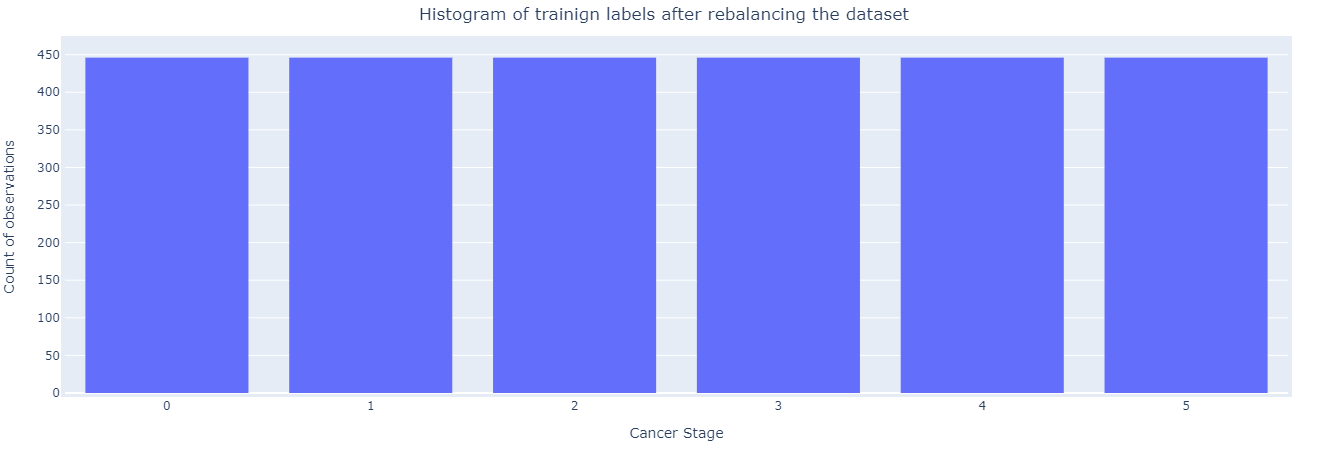

In [62]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=y_train))

# Overlay both histograms
fig.update_layout(bargroupgap=0.2,
                  title="Histogram of trainign labels after rebalancing the dataset",
                  xaxis_title="Cancer Stage",
                  yaxis_title="Count of observations")
fig.update_layout(
    margin=dict(
        l=40,
        r=40,
        b=40,
        t=40,
        pad=4
    ),
    title={
        'x':0.5})
fig.show()

# Modeling

In [63]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [15]:
kf = StratifiedKFold(n_splits=4)

param_test1 = {
    'max_depth': range(3,10,2),
    'min_child_weight': range(1,6,2),
    'gamma':[i/10.0 for i in range(0,5)],
    'alpha':[6,8,10,12]
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(objective= 'multi:softmax', 
                                                  colsample_bytree = 0.8, 
                                                  learning_rate = 0.1, 
                                                  max_depth = 5, 
                                                  gamma=0, alpha = 10, 
                                                  n_estimators = 10, 
                                                  num_class = 6, 
                                                  min_child_weight=1, 
                                                  subsample=0.8, 
                                                  nthread=4
                                                     ), 
                        param_grid = param_test1, scoring='f1_weighted',n_jobs=4, cv=5)
gsearch1.fit(X_train, y_train)
gsearch1.best_params_

{'alpha': 6, 'gamma': 0.1, 'max_depth': 9, 'min_child_weight': 1}

In [64]:
xg_reg = xgb.XGBClassifier(objective ='multi:softmax', colsample_bytree = 0.8, learning_rate = 0.1, max_depth = 9, gamma = 0.1, alpha = 6, n_estimators = 10, num_class = 6, min_child_weight = 1)

In [65]:
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

In [66]:
m = classification_report(y_test, preds)
print(m)

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94        39
         1.0       0.20      0.17      0.19        53
         2.0       0.58      0.64      0.61       184
         3.0       0.35      0.28      0.31        82
         4.0       0.11      0.17      0.13         6
         5.0       0.00      0.00      0.00         3

    accuracy                           0.51       367
   macro avg       0.36      0.38      0.36       367
weighted avg       0.50      0.51      0.50       367



In [67]:
most_useful_sites = sorted(zip(range(0, len(cpg_sites)), cpg_sites, xg_reg.feature_importances_), key=lambda x: x[2], reverse=1)[:20]
print("The 20 most useful CpG site are:")
print([elt[1] for elt in most_useful_sites])

The 20 most useful CpG site are:
['cg11394785', 'cg14654385', 'cg16098726', 'cg00548268', 'cg00911873', 'cg07981495', 'cg24949049', 'cg13179915', 'cg12731488', 'cg18783781', 'cg01216369', 'cg11378052', 'cg03399971', 'cg10660256', 'cg23128056', 'cg17349199', 'cg01381846', 'cg10150530', 'cg26259363', 'cg10677144']


In [68]:
# Evaluate Model

## Metrics

Let's compute the raw accuracy score as a rough proxy for model performance. In a multi-class classification problem, the accuracy is defined as the number of observation classified in the correct class divided by the total number of observations.

First, on the training set

In [69]:
# Training
training_predicted_labels = xg_reg.predict(X_train)
acc_training = accuracy_score(training_predicted_labels, y_train)
print(f"The train accuracy is {acc_training:.3f}")

The train accuracy is 0.998


Then, on the test set

In [70]:
# Testing
testing_predicted_labels = xg_reg.predict(X_test)
acc_testing = accuracy_score(testing_predicted_labels, y_test)
print(f"The test accuracy is {acc_testing:.2f}")

The test accuracy is 0.51


## Confusion Matrix

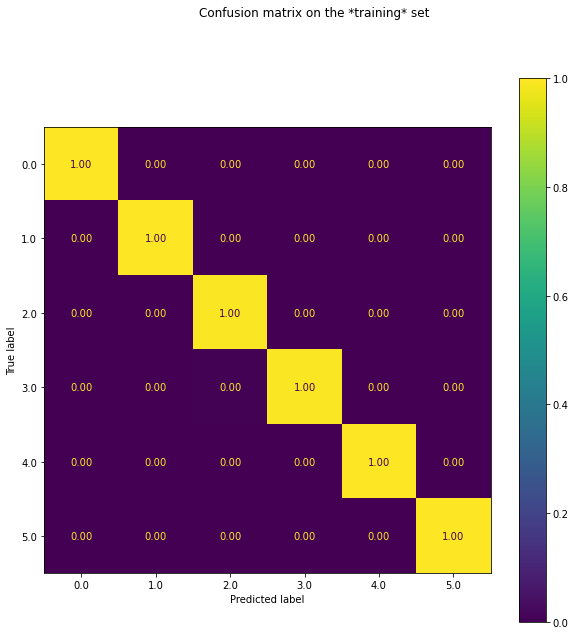

In [71]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
f.suptitle("Confusion matrix on the *training* set")
plot_confusion_matrix(xg_reg, X_train, y_train, ax=ax, values_format='.2f', normalize='true');

In [72]:
m = classification_report(y_train, xg_reg.predict(X_train))
print(m)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       446
         1.0       1.00      1.00      1.00       446
         2.0       0.99      1.00      0.99       446
         3.0       1.00      1.00      1.00       446
         4.0       1.00      1.00      1.00       446
         5.0       1.00      1.00      1.00       446

    accuracy                           1.00      2676
   macro avg       1.00      1.00      1.00      2676
weighted avg       1.00      1.00      1.00      2676



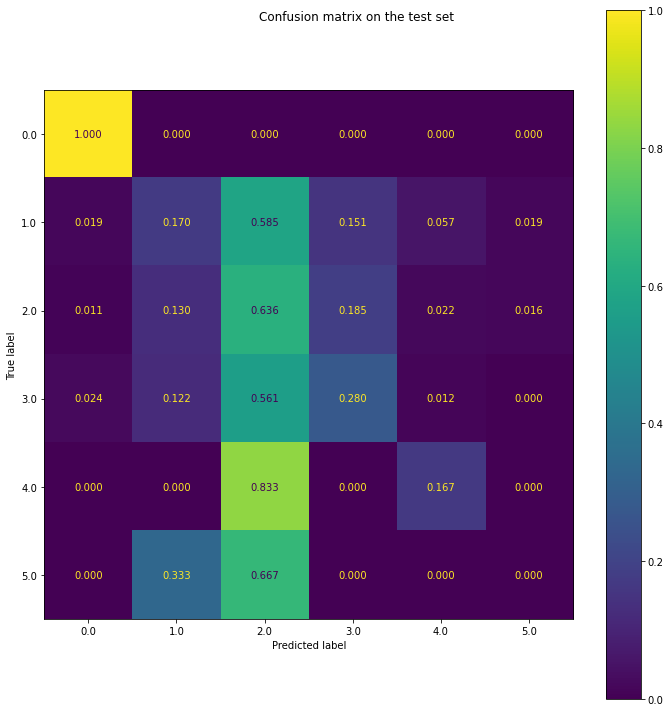

In [73]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
f.suptitle("Confusion matrix on the test set")
plot_confusion_matrix(xg_reg, X_test, y_test, ax=ax, values_format='.3f', normalize='true')
f.tight_layout()
f.savefig("confusion_matrix.png", dpi=200)